In [1]:
# the sourse of code go from https://www.quantopian.com/posts/machine-learning-on-quantopian

# import libraries
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import Latest
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import CustomFactor, SimpleMovingAverage, AverageDollarVolume, Returns, RSI
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline.filters import Q500US, Q1500US
from quantopian.pipeline.data.quandl import fred_usdontd156n as libor
from quantopian.pipeline.data.zacks import EarningsSurprises

import talib
import pandas as pd
import numpy as np
from time import time

import alphalens as al
import pyfolio as pf
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, decomposition, ensemble, preprocessing, isotonic, metrics

In [2]:
#definition of factors
bs = morningstar.balance_sheet
cfs = morningstar.cash_flow_statement
is_ = morningstar.income_statement
or_ = morningstar.operation_ratios
er = morningstar.earnings_report
v = morningstar.valuation
vr = morningstar.valuation_ratios


def make_factors():
    def Asset_Growth_3M():
        return Returns(inputs=[bs.total_assets], window_length=63)

    def Asset_To_Equity_Ratio():
        return bs.total_assets.latest / bs.common_stock_equity.latest

    def Capex_To_Cashflows():
        return (cfs.capital_expenditure.latest * 4.) / \
            (cfs.free_cash_flow.latest * 4.)
        
    def EBITDA_Yield():
        return (is_.ebitda.latest * 4.) / \
            USEquityPricing.close.latest        

    def EBIT_To_Assets():
        return (is_.ebit.latest * 4.) / \
            bs.total_assets.latest
        
    def Earnings_Quality():
        return morningstar.cash_flow_statement.operating_cash_flow.latest / \
               EarningsSurprises.eps_act.latest
        
    def Return_On_Total_Invest_Capital():
        return or_.roic.latest
    
    class Mean_Reversion_1M(CustomFactor):
        inputs = [Returns(window_length=21)]
        window_length = 252

        def compute(self, today, assets, out, monthly_rets):
            out[:] = (monthly_rets[-1] - np.nanmean(monthly_rets, axis=0)) / \
                np.nanstd(monthly_rets, axis=0)
                
    class MACD_Signal_10d(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 60

        def compute(self, today, assets, out, close):

            sig_lines = []

            for col in close.T:
                # get signal line only
                try:
                    _, signal_line, _ = talib.MACD(col, fastperiod=12,
                                                   slowperiod=26, signalperiod=10)
                    sig_lines.append(signal_line[-1])
                # if error calculating, return NaN
                except:
                    sig_lines.append(np.nan)
            out[:] = sig_lines 
            
    class Moneyflow_Volume_5d(CustomFactor):
        inputs = [USEquityPricing.close, USEquityPricing.volume]
        window_length = 5

        def compute(self, today, assets, out, close, volume):

            mfvs = []

            for col_c, col_v in zip(close.T, volume.T):

                # denominator
                denominator = np.dot(col_c, col_v)

                # numerator
                numerator = 0.
                for n, price in enumerate(col_c.tolist()):
                    if price > col_c[n - 1]:
                        numerator += price * col_v[n]
                    else:
                        numerator -= price * col_v[n]

                mfvs.append(numerator / denominator)
            out[:] = mfvs  
            
           
    def Net_Income_Margin():
        return or_.net_margin.latest           

    def Operating_Cashflows_To_Assets():
        return (cfs.operating_cash_flow.latest * 4.) / \
            bs.total_assets.latest

    def Price_Momentum_3M():
        return Returns(window_length=63)
    
    class Price_Oscillator(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        def compute(self, today, assets, out, close):
            four_week_period = close[-20:]
            out[:] = (np.nanmean(four_week_period, axis=0) /
                      np.nanmean(close, axis=0)) - 1.
    
    def Returns_39W():
        return Returns(window_length=215)
    
    class Trendline(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        # using MLE for speed
        def compute(self, today, assets, out, close):

            # prepare X matrix (x_is - x_bar)
            X = range(self.window_length)
            X_bar = np.nanmean(X)
            X_vector = X - X_bar
            X_matrix = np.tile(X_vector, (len(close.T), 1)).T

            # prepare Y matrix (y_is - y_bar)
            Y_bar = np.nanmean(close, axis=0)
            Y_bars = np.tile(Y_bar, (self.window_length, 1))
            Y_matrix = close - Y_bars

            # prepare variance of X
            X_var = np.nanvar(X)

            # multiply X matrix an Y matrix and sum (dot product)
            # then divide by variance of X
            # this gives the MLE of Beta
            out[:] = (np.sum((X_matrix * Y_matrix), axis=0) / X_var) / \
                (self.window_length)
        
    class Vol_3M(CustomFactor):
        inputs = [Returns(window_length=2)]
        window_length = 63

        def compute(self, today, assets, out, rets):
            out[:] = np.nanstd(rets, axis=0)
            
    def Working_Capital_To_Assets():
        return bs.working_capital.latest / bs.total_assets.latest   
        
    all_factors = {
        'Asset Growth 3M': Asset_Growth_3M,
        'Asset to Equity Ratio': Asset_To_Equity_Ratio,
        'Capex to Cashflows': Capex_To_Cashflows,
        'EBIT to Assets': EBIT_To_Assets,
        'EBITDA Yield': EBITDA_Yield,        
        #'Earnings Quality': Earnings_Quality,
        'MACD Signal Line': MACD_Signal_10d,
        'Mean Reversion 1M': Mean_Reversion_1M,
        'Moneyflow Volume 5D': Moneyflow_Volume_5d,
        'Net Income Margin': Net_Income_Margin,        
        'Operating Cashflows to Assets': Operating_Cashflows_To_Assets,
        'Price Momentum 3M': Price_Momentum_3M,
        'Price Oscillator': Price_Oscillator,
        'Return on Invest Capital': Return_On_Total_Invest_Capital,
        '39 Week Returns': Returns_39W,
        'Trendline': Trendline,
        'Vol 3M': Vol_3M,
        'Working Capital to Assets': Working_Capital_To_Assets,        
    }        
    
    return all_factors
factors = make_factors()

In [3]:
universe = Q500US() # Define universe and select factors to use
n_fwd_days = 5 # number of days to compute returns over

Differently to source I changed rank to zscore!  

In [77]:
# Define and build the pipeline
def make_history_pipeline(factors, universe, n_fwd_days=5):
    # Call .rank() on all factors and mask out the universe
    factor_zscore = {name: f().zscore(mask=universe) for name, f in factors.iteritems()}
    # Get cumulative returns over last n_fwd_days days. We will later shift these.
    factor_zscore['Returns'] = Returns(inputs=[USEquityPricing.open],
                                      mask=universe, window_length=n_fwd_days)
    
    # Add many returns as factors
    for i in [10,20,30,60,100,250]:
        factor_zscore ['Return'+str(i)] = Returns(inputs=[USEquityPricing.open],
                                      mask=universe, window_length=i)    
    
    #factor_zscore['SPY']=Returns(inputs=[USEquityPricing.open('SPY')] )
    
    pipe = Pipeline(screen=universe, columns=factor_zscore)
    
    return pipe
history_pipe = make_history_pipeline(factors, universe, n_fwd_days=n_fwd_days)

In [78]:
# Because of problem with  time when taken a lot of data divide time to periods
end_full = pd.Timestamp("2017-08-07")
period = pd.DateOffset(50)
number_of_periods = 1
results=pd.DataFrame()
start = end_full-number_of_periods*(period)-(number_of_periods-1)*pd.DateOffset(1)

In [79]:
# Run pipeline
start_timer = time()
while end_full>start:
    print 'start', start ,'end' ,start+period
    results_period = run_pipeline(history_pipe, start_date=start, end_date=start+period)
    start+=(period+pd.DateOffset(1))
    results_period.index.names = ['date', 'security']
    results=pd.concat([results,results_period])
end_timer = time()
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

start 2017-06-18 00:00:00 end 2017-08-07 00:00:00
Time to run pipeline 55.88 secs


In [80]:
results.head()

39 Week Returns  \
date                      security                              
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])          0.665728   
                          Equity(62 [ABT])          -0.133186   
                          Equity(67 [ADSK])          2.014238   
                          Equity(76 [TAP])          -0.831579   
                          Equity(114 [ADBE])         0.781539   

                                              Asset Growth 3M  \
date                      security                              
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])         -0.092925   
                          Equity(62 [ABT])           3.027409   
                          Equity(67 [ADSK])         -0.897876   
                          Equity(76 [TAP])          -0.124305   
                          Equity(114 [ADBE])        -0.188100   

                                              Asset to Equity Ratio  \
date                      security                                    
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])               -0.069029   
                          Equity(62 [ABT])                -0.074402   
                          Equity(67 [ADSK])                0.073510   
                          Equity(76 [TAP])                -0.067835   
                          Equity(114 [ADBE])              -0.086794   

                                              Capex to Cashflows  \
date                      security                                 
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])            -0.043046   
                          Equity(62 [ABT])             -0.107278   
                          Equity(67 [ADSK])            -0.034007   
                          Equity(76 [TAP])              0.058274   
                          Equity(114 [ADBE])           -0.013006   

                                              EBIT to Assets  EBITDA Yield  \
date                      security                                           
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])         0.738529      2.258280   
                          Equity(62 [ABT])         -0.287849      0.349901   
                          Equity(67 [ADSK])        -1.592555     -0.456004   
                          Equity(76 [TAP])         -0.322391     -0.294512   
                          Equity(114 [ADBE])        0.456196     -0.348290   

                                              MACD Signal Line  \
date                      security                               
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])          -0.143788   
                          Equity(62 [ABT])            0.054496   
                          Equity(67 [ADSK])           1.245084   
                          Equity(76 [TAP])           -0.720180   
                          Equity(114 [ADBE])          0.343325   

                                              Mean Reversion 1M  \
date                      security                                
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])           -2.456057   
                          Equity(62 [ABT])             1.604299   
                          Equity(67 [ADSK])            0.343737   
                          Equity(76 [TAP])            -1.705451   
                          Equity(114 [ADBE])          -0.414388   

                                              Moneyflow Volume 5D  \
date                      security                                  
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])             -0.072704   
                          Equity(62 [ABT])               1.917903   
                          Equity(67 [ADSK])              0.219742   
                          Equity(76 [TAP])              -0.391036   
                          Equity(114 [ADBE])            -1.191966   

                                              Net Income Margin  \
date                      security                                
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])            0.1058

In [81]:
# Sometimes there are duplicated indexis
results = results[~results.index.duplicated(keep='first')]
# Massage data to be in the form expected by shift_mask_data()
results_wo_returns = results.copy()
returns = results_wo_returns.pop('Returns')
Y = returns.unstack().values
X = results_wo_returns.to_panel() 
X = X.swapaxes(2, 0).swapaxes(0, 1).values # (factors, time, stocks) -> (time, stocks, factors)
results_wo_returns.index = results_wo_returns.index.set_levels(
    results_wo_returns.index.get_level_values(1).map(lambda x: x.symbol), 1, )
results_wo_returns.index = results_wo_returns.index.set_levels(
    results_wo_returns.index.get_level_values(0).map(lambda x: x.date), 0, )

# Train-test split
train_size_perc = 0.5
n_time, n_stocks, n_factors = X.shape
train_size = np.int16(np.round(train_size_perc * n_time))
X_train, Y_train = X[:train_size, ...], Y[:train_size]
X_test, Y_test = X[(train_size+n_fwd_days):, ...], Y[(train_size+n_fwd_days):]

In [82]:
def shift_mask_data_absolut_return(X, Y, n_fwd_days=1):
    # Shift X to match factors at t to returns at t+n_fwd_days (we want to predict future returns after all)
    shifted_X = np.roll(X, n_fwd_days+1, axis=0)
    
    # Slice off rolled elements
    X = shifted_X[n_fwd_days+1:]
    Y = Y[n_fwd_days+1:]
    
    n_time, n_stocks, n_factors = X.shape
    level=0.01
    upper_mask = (Y > level)
    lower_mask = (Y <= level)
    
    
    # Try to predict the price go up to level 
    Y_binary = np.zeros(n_time * n_stocks)
    Y_binary[upper_mask.flatten()] =  1
    Y_binary[lower_mask.flatten()] = 0

    # Flatten X
    X = X.reshape((n_time * n_stocks, n_factors))
    
    return X, Y_binary

In [83]:
def shift_mask_data(X, Y, upper_percentile=60, lower_percentile=40, n_fwd_days=1):
    # Shift X to match factors at t to returns at t+n_fwd_days (we want to predict future returns after all)
    shifted_X = np.roll(X, n_fwd_days+1, axis=0)
    
    # Slice off rolled elements
    X = shifted_X[n_fwd_days+1:]
    Y = Y[n_fwd_days+1:]
    
    n_time, n_stocks, n_factors = X.shape
    
    # Look for biggest up and down movers
    upper = np.nanpercentile(Y, upper_percentile, axis=1)[:, np.newaxis]
    lower = np.nanpercentile(Y, lower_percentile, axis=1)[:, np.newaxis]
  
    upper_mask = (Y >= upper)
    lower_mask = (Y <= lower)
    
    mask = upper_mask | lower_mask # This also drops nans
    mask = mask.flatten()
    
    # Only try to predict whether a stock moved up/down relative to other stocks
    Y_binary = np.zeros(n_time * n_stocks)
    Y_binary[upper_mask.flatten()] = 0
    Y_binary[lower_mask.flatten()] = 1
    
    # Flatten X
    X = X.reshape((n_time * n_stocks, n_factors))

    # Drop stocks that did not move much (i.e. are in the 30th to 70th percentile)
    X = X[mask]
    Y_binary = Y_binary[mask]
    
    return X, Y_binary

In [84]:
X_train_shift, Y_train_shift = shift_mask_data(X_train, Y_train, n_fwd_days=n_fwd_days, 
                                             lower_percentile=30,
                                             upper_percentile=70)
X_test_shift, Y_test_shift = shift_mask_data(X_test, Y_test, n_fwd_days=n_fwd_days, 
                                             lower_percentile=50, 
                                             upper_percentile=50)

print X_train_shift.shape, X_test_shift.shape
print Y_train_shift.shape, Y_test_shift.shape

(3600, 23) (2996, 23)
(3600,) (2996,)


In [85]:
imputer = preprocessing.Imputer()
scaler = preprocessing.MinMaxScaler()
X_train_trans = imputer.fit_transform(X_train_shift)
X_train_trans = scaler.fit_transform(X_train_trans)
X_test_trans = imputer.transform(X_test_shift)
X_test_trans = scaler.transform(X_test_trans)
print X_train_trans.shape, X_test_trans.shape

(3600, 23) (2996, 23)


In [98]:
cls_metrics = {
            'accuracy': metrics.accuracy_score,
            'precision':metrics.precision_score,
            'recall': metrics.recall_score ,
            'f1':metrics.f1_score,  
                }
metric_colors = {
            'accuracy': 'r',
             'precision':'b',
            'recall': 'g' ,
            'f1':'orange',
            'time':'blue',
            'time_PCA':'black'
                }

1 2 3 5 6 7 15 10 40 50 100 200 300 500 1000

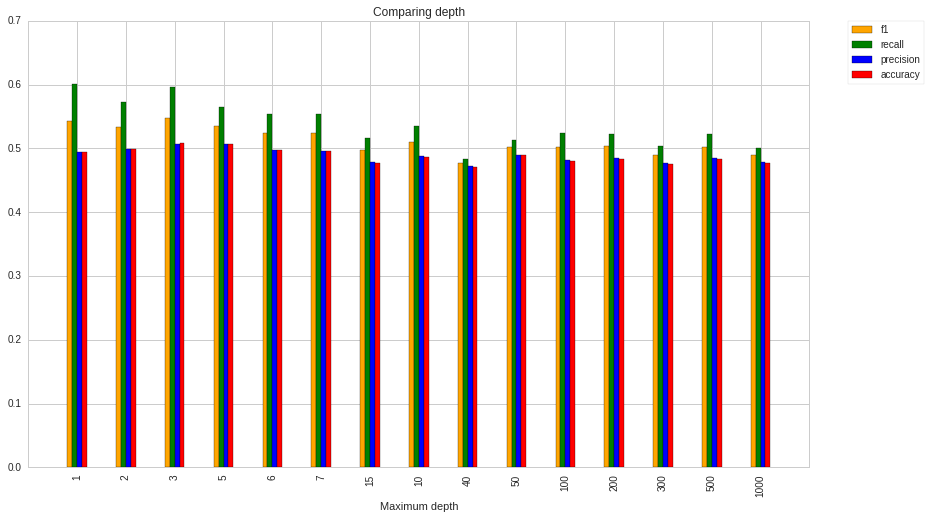

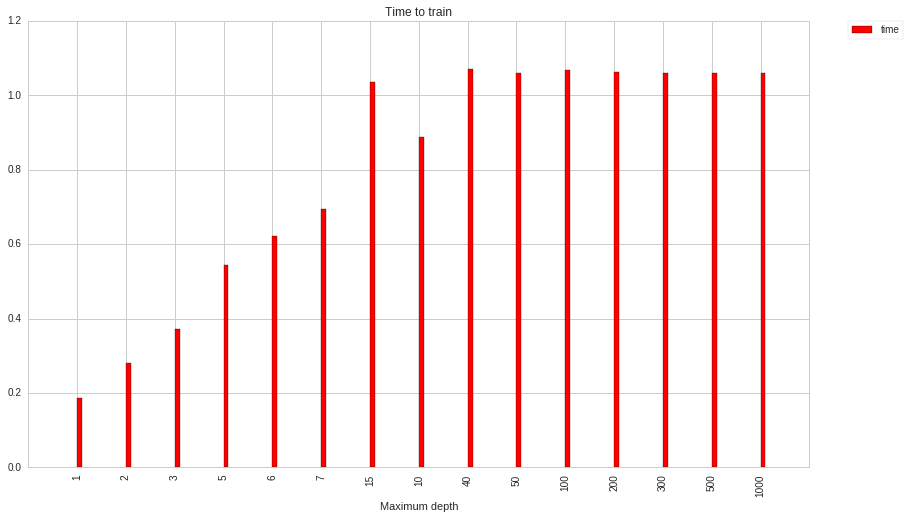

 f1 for depth 3 max value 0.548189073051
recall for depth 1 max value 0.600801068091
precision for depth 3 max value 0.507386363636
accuracy for depth 3 max value 0.50867823765


In [99]:
metric_results_RF={}
for metric in cls_metrics:
    metric_results_RF.update({metric:[]})
    metric_results_RF.update({'time':[]});
depths =  np.array([1,2,3,5,6,7,15,10,40,50,100,200,300,500, 1000])
    
for depth in depths:
    start_timer = time()
    clf = ensemble.RandomForestClassifier(max_depth=depth,n_estimators=100) 
    clf.fit(X_train_trans, Y_train_shift)
    
    Y_pred_test = clf.predict(X_test_trans)
    end_timer = time()
    print depth,
    
    for metric in cls_metrics:         
        temp = cls_metrics[metric](Y_test_shift, Y_pred_test)
        metric_results_RF[metric].append(temp)
    
    metric_results_RF['time'].append(end_timer-start_timer)
    
mywidth = 0.1
shift = -(len(cls_metrics)-1)/2*mywidth

for metric in cls_metrics:
       
    plt.bar(np.array(range(1,len(depths)+1))+shift, metric_results_RF[metric], width=mywidth,
        label = metric, color=metric_colors[metric])
    shift += mywidth
   
plt.title("Comparing depth")
plt.xlabel('Maximum depth')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(np.array(range(1,len(depths)+1)), depths, rotation='vertical')
plt.show()    

plt.bar(np.array(range(1,len(depths)+1)), metric_results_RF['time'], width=mywidth,
        label = 'time', color=metric_colors[metric])
plt.title("Time to train")
plt.xlabel('Maximum depth')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(np.array(range(1,len(depths)+1)), depths, rotation='vertical')

plt.show()

for metric in cls_metrics:
    print metric, 'for depth', depths[np.argmax(metric_results_RF[metric])] \
    ,'max value', max(metric_results_RF[metric])

10 20 30 40 50 70 100 200 300 400 500 600 1000

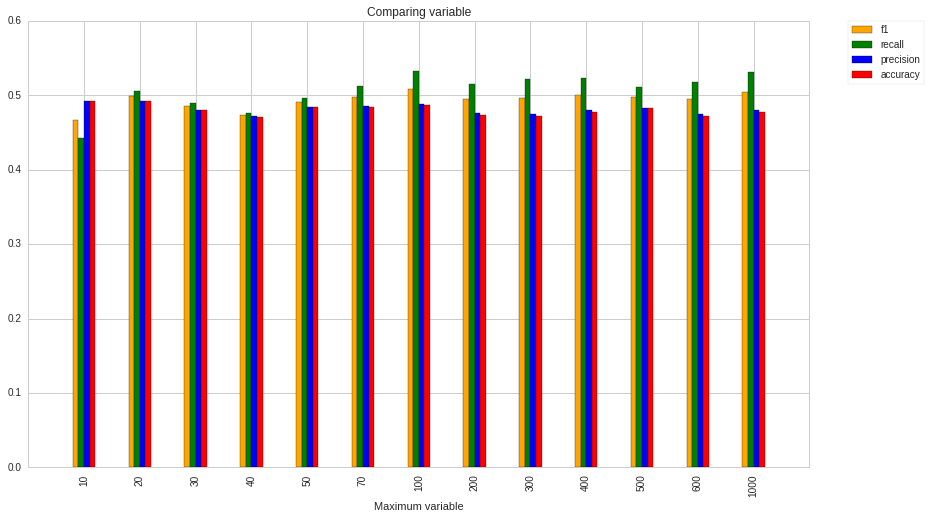

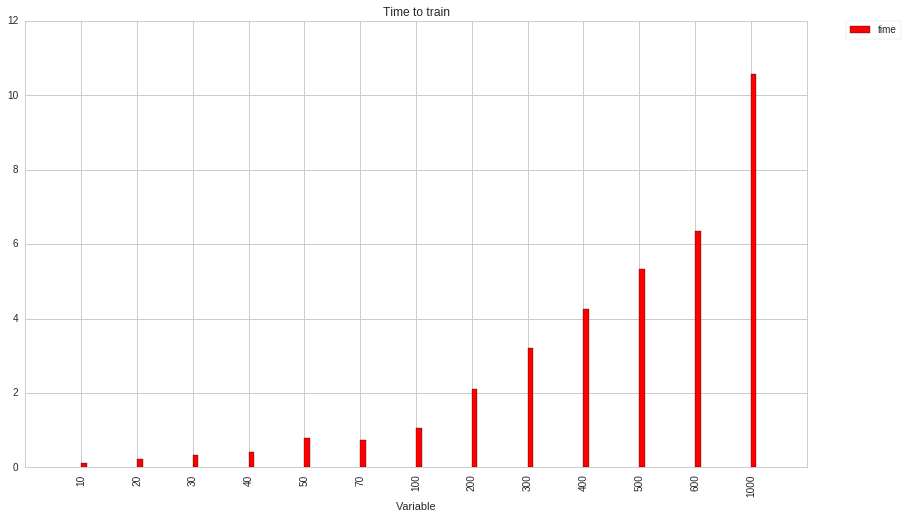

 max f1 for variable 100 max value 0.509102523156
max recall for variable 100 max value 0.532042723632
max precision for variable 20 max value 0.492847854356
max accuracy for variable 10 max value 0.492656875834


In [100]:
metric_results_RF={}
for metric in cls_metrics:
    metric_results_RF.update({metric:[]})
    metric_results_RF.update({'time':[]});
    
changed_variables =  np.array([10,20,30,40,50,70,100,200,300,400,500, 600, 1000])
    
for changed_variable in changed_variables:
    start_timer = time()
    clf = ensemble.RandomForestClassifier(max_depth=30,n_estimators=changed_variable) 
    clf.fit(X_train_trans, Y_train_shift)
    
    Y_pred_test = clf.predict(X_test_trans)
    end_timer = time()
    print changed_variable,
    
    for metric in cls_metrics:         
        temp = cls_metrics[metric](Y_test_shift, Y_pred_test)
        metric_results_RF[metric].append(temp)
    
    metric_results_RF['time'].append(end_timer-start_timer)
    
mywidth = 0.1
shift = -(len(cls_metrics)-1)/2*mywidth

for metric in cls_metrics:
       
    plt.bar(np.array(range(1,len(changed_variables)+1))+shift, metric_results_RF[metric], width=mywidth,
        label = metric, color=metric_colors[metric])
    shift += mywidth
   
plt.title("Comparing variable")
plt.xlabel('Maximum variable')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(np.array(range(1,len(changed_variables)+1)), changed_variables, rotation='vertical')
plt.show()    

plt.bar(np.array(range(1,len(changed_variables)+1)), metric_results_RF['time'], width=mywidth,
        label = 'time', color=metric_colors[metric])
plt.title("Time to train")
plt.xlabel('Variable')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(np.array(range(1,len(changed_variables)+1)), changed_variables, rotation='vertical')
plt.show()

for metric in cls_metrics:
    print 'max', metric, 'for variable', changed_variables[np.argmax(metric_results_RF[metric])] \
    ,'max value', max(metric_results_RF[metric])


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23

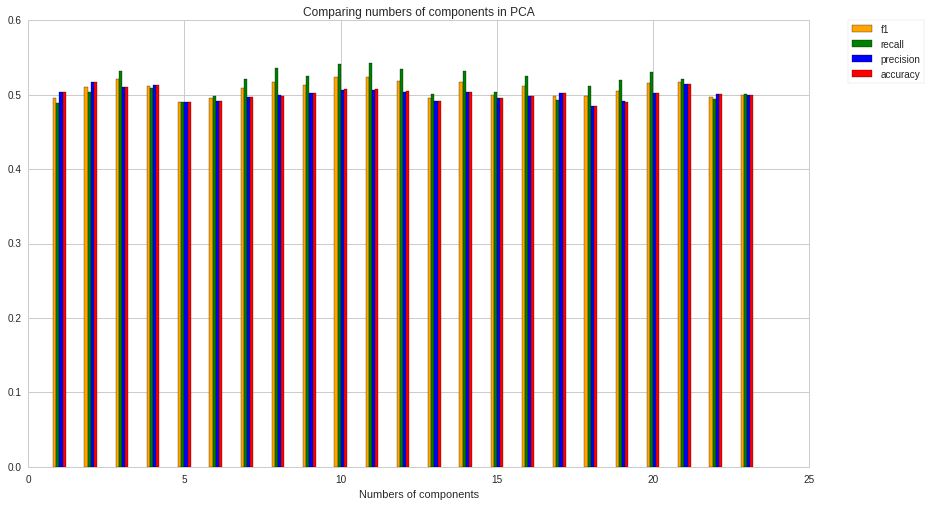

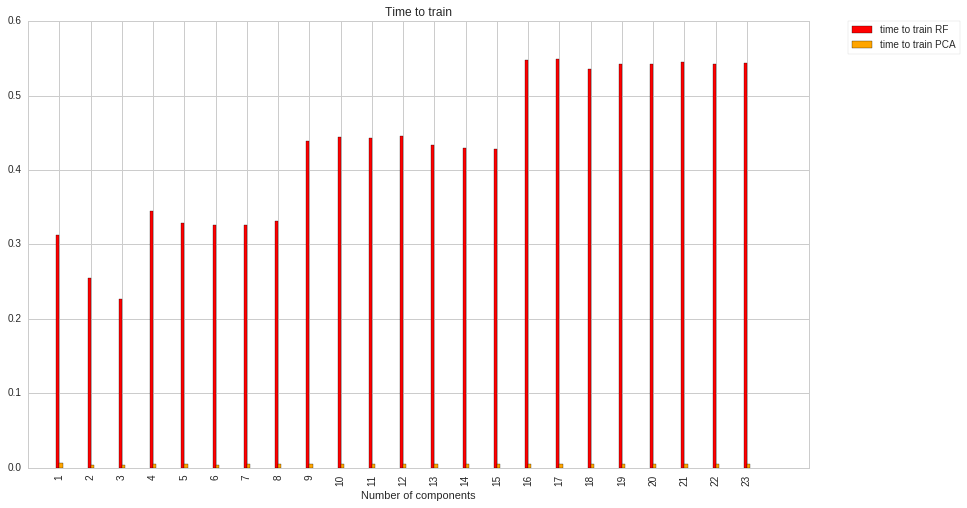

 max f1 for number of components 11 max value 0.524484536082
max recall for number of components 11 max value 0.543391188251
max precision for number of components 2 max value 0.517501715854
max accuracy for number of components 2 max value 0.517022696929


In [101]:
metric_results_PCA={}
for metric in cls_metrics:
    metric_results_PCA.update({metric:[]});
    metric_results_PCA.update({'time':[]});
    metric_results_PCA.update({'time_PCA':[]});
pca_numbers = np.array(range(1,X.shape[2]+1))  
clf = ensemble.RandomForestClassifier(max_depth=30,n_estimators=50) 
    
for pca_number in pca_numbers :
    print pca_number,
    pca=decomposition.PCA(n_components = pca_number)
    start_timer_PCA=time()
    X_train_trans_PCA = pca.fit_transform(X_train_trans)
    X_test_trans_PCA = pca.transform(X_test_trans)
    end_timer_PCA=time()
    
    start_timer=time()
    clf.fit(X_train_trans_PCA, Y_train_shift)
    Y_pred_test_PCA    = clf.predict(X_test_trans_PCA)
    end_timer=time()

    
    for metric in cls_metrics:         
        temp = cls_metrics[metric](Y_test_shift, Y_pred_test_PCA)
        metric_results_PCA[metric].append(temp)
    
    metric_results_PCA['time'].append(end_timer-start_timer)
    metric_results_PCA['time_PCA'].append(end_timer_PCA-start_timer_PCA)

    mywidth =0.1
    
    
shift=-(len(cls_metrics)-1)/2*mywidth
for metric in cls_metrics:
        
    plt.bar(pca_numbers+shift, metric_results_PCA[metric], width=mywidth,
        label = metric, color=metric_colors[metric])
    shift += mywidth
   

plt.title("Comparing numbers of components in PCA")
plt.xlabel('Numbers of components')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.bar(np.array(range(1,len(pca_numbers)+1))-mywidth, metric_results_PCA['time'], width=mywidth,
        label = 'time to train RF', color='r')
plt.bar(np.array(range(1,len(pca_numbers)+1)), metric_results_PCA['time_PCA'], width=mywidth,
        label = 'time to train PCA', color='orange')

plt.title("Time to train")
plt.xlabel('Number of components')
plt.xticks(np.array(range(1,len(pca_numbers)+1)), pca_numbers, rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()



for metric in cls_metrics:
    print 'max', metric, 'for number of components', pca_numbers[np.argmax(metric_results_PCA[metric])] \
    ,'max value', max(metric_results_PCA[metric])

In [107]:
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [108]:
def get_last_values(input_data):
    last_values = []
    for dataset in input_data:
        last_values.append(dataset[-1])
    return np.vstack(last_values).T

In [134]:
class ML(CustomFactor):
    init = False
    def compute(self, today, assets, out, returns, *inputs):
        # inputs is a list of factors, for example, assume we have 2 alpha signals, 3 stocks,
        # and a lookback of 2 days. Each element in the inputs list will be data of
        # one signal, so len(inputs) == 2. Then each element will contain a 2-D array
        # of shape [time x stocks]. For example:
        # inputs[0]:
        # [[1, 3, 2], # factor 1 rankings of day t-1 for 3 stocks  
        #  [3, 2, 1]] # factor 1 rankings of day t for 3 stocks
        # inputs[1]:
        # [[2, 3, 1], # factor 2 rankings of day t-1 for 3 stocks
        #  [1, 2, 3]] # factor 2 rankings of day t for 3 stocks
        
        if (not self.init) or (today.weekday == 0): # Monday
            # Instantiate sklearn objects
            self.imputer = imputer
            self.scaler = scaler
            self.clf = clf
        # Predict
        # Get most recent factor values (inputs always has the full history)
        last_factor_values = get_last_values(inputs)
        last_factor_values = self.imputer.transform(last_factor_values)
        last_factor_values = self.scaler.transform(last_factor_values)

        # Predict the probability for each stock going up 
        # (column 2 of the output of .predict_proba()) and
        # return it via assignment to out.
        out[:] = self.clf.predict_proba(last_factor_values)[:, 1]*100

In [148]:
from collections import OrderedDict

def make_ml_pipeline(factors, universe, window_length=5, n_fwd_days=2):
    factors_pipe = OrderedDict()
    # Create returns over last n days.
    factors_pipe['Returns'] = Returns(inputs=[USEquityPricing.open],
                                      mask=universe, window_length=n_fwd_days)
    
    for i in [10,20,30,60,100,250]:
        factors_pipe ['Return'+str(i)] = Returns(inputs=[USEquityPricing.open],
                                      mask=universe, window_length=i)    
    # Instantiate ranked factors
    for name, f in factors.iteritems():
        factors_pipe[name] = f().zscore(mask=universe)
        
    # Create our ML pipeline factor. The window_length will control how much
    # lookback the passed in data will have.
    factors_pipe['ML'] = ML(inputs=factors_pipe.values(), 
                            window_length=window_length + 1, 
                            mask=universe)
    factors_pipe['ML_zscore']=factors_pipe['ML'].zscore(mask=universe)
    factors_pipe['ML_ranked']=factors_pipe['ML'].rank(mask=universe)
    
    pipe = Pipeline(screen=universe, columns=factors_pipe)
    
    return pipe

ml_pipe = make_ml_pipeline(factors, universe)

In [149]:
start_timer = time()
start = pd.Timestamp("2015-01-01") # Can't choose a much longer time-period or we run out of RAM
end = pd.Timestamp("2015-03-01")

results = run_pipeline(ml_pipe, start_date=start, end_date=end)

end_timer = time()
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

Time to run pipeline 46.96 secs


In [150]:
results['ML_ranked']

2015-01-02 00:00:00+00:00  Equity(2 [ARNC])         38.0
                           Equity(24 [AAPL])       124.0
                           Equity(62 [ABT])        125.0
                           Equity(67 [ADSK])        39.0
                           Equity(76 [TAP])        126.0
                           Equity(114 [ADBE])       40.0
                           Equity(122 [ADI])       492.0
                           Equity(128 [ADM])       127.0
                           Equity(161 [AEP])        41.0
                           Equity(168 [AET])       128.0
                           Equity(185 [AFL])       129.0
                           Equity(205 [AGN])       130.0
                           Equity(216 [HES])       131.0
                           Equity(239 [AIG])        42.0
                           Equity(328 [ALTR])      132.0
                           Equity(337 [AMAT])      133.0
                           Equity(351 [AMD])         8.0
                           Equi

In [151]:
assets = results.index.levels[1]
pricing = get_pricing(assets, start, end + pd.Timedelta(days=30), fields="open_price")

In [152]:
pricing.shape

(61, 519)

In [153]:
results.columns

Index([u'39 Week Returns', u'Asset Growth 3M', u'Asset to Equity Ratio',
       u'Capex to Cashflows', u'EBIT to Assets', u'EBITDA Yield',
       u'MACD Signal Line', u'ML', u'ML_ranked', u'ML_zscore',
       u'Mean Reversion 1M', u'Moneyflow Volume 5D', u'Net Income Margin',
       u'Operating Cashflows to Assets', u'Price Momentum 3M',
       u'Price Oscillator', u'Return on Invest Capital', u'Return10',
       u'Return100', u'Return20', u'Return250', u'Return30', u'Return60',
       u'Returns', u'Trendline', u'Vol 3M', u'Working Capital to Assets'],
      dtype='object')

In [154]:
results.ML.iloc[1]

54.0

In [155]:
results['Asset Growth 3M'].head()

2015-01-02 00:00:00+00:00  Equity(2 [ARNC])    -0.043744
                           Equity(24 [AAPL])    0.065204
                           Equity(62 [ABT])    -0.028872
                           Equity(67 [ADSK])   -0.129221
                           Equity(76 [TAP])    -0.535064
Name: Asset Growth 3M, dtype: float64

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated and will be removed in the future. Please use the new API instead.
  """Entry point for launching an IPython kernel.


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,1.0,101.0,50.635500,28.984145,4000,20.077298
2,101.0,201.0,150.651759,28.769309,3980,19.976911
3,200.0,301.0,250.139078,28.776396,3969,19.921699
4,299.0,400.0,349.909799,28.841346,3980,19.976911
5,398.0,500.0,449.677016,28.847828,3994,20.047182


Returns Analysis


,1,5,10
Ann. alpha,0.044,0.024,-0.020
beta,-0.003,0.034,0.068
Mean Period Wise Return Top Quantile (bps),3.772,17.383,11.680
Mean Period Wise Return Bottom Quantile (bps),-0.458,4.530,27.616
Mean Period Wise Spread (bps),4.223,2.553,-1.606


Information Analysis


,1,5,10
IC Mean,0.004,0.003,-0.017
IC Std.,0.059,0.050,0.051
t-stat(IC),0.413,0.359,-2.074
p-value(IC),0.682,0.721,0.045
IC Skew,0.353,0.285,-0.243
IC Kurtosis,-0.173,-0.968,-0.810
Ann. IR,1.036,0.901,-5.206


Turnover Analysis


,1,5,10
Quantile 1 Mean Turnover,0.119,0.257,0.353
Quantile 2 Mean Turnover,0.164,0.346,0.475
Quantile 3 Mean Turnover,0.147,0.304,0.421
Quantile 4 Mean Turnover,0.168,0.328,0.401
Quantile 5 Mean Turnover,0.137,0.276,0.374


,1,5,10
Mean Factor Rank Autocorrelation,0.896,0.763,0.656


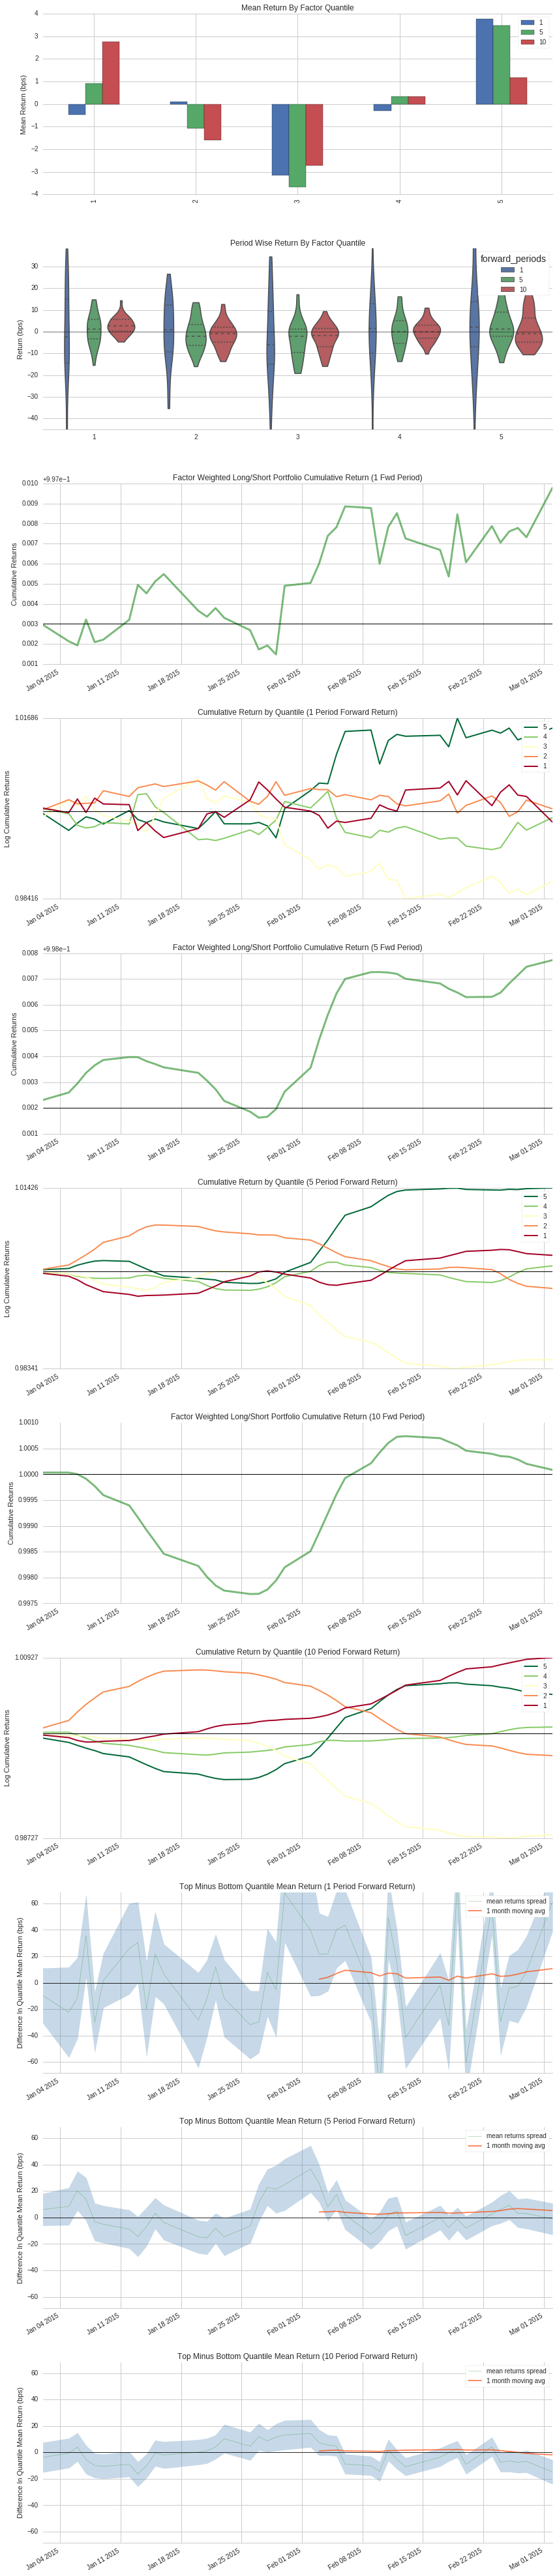

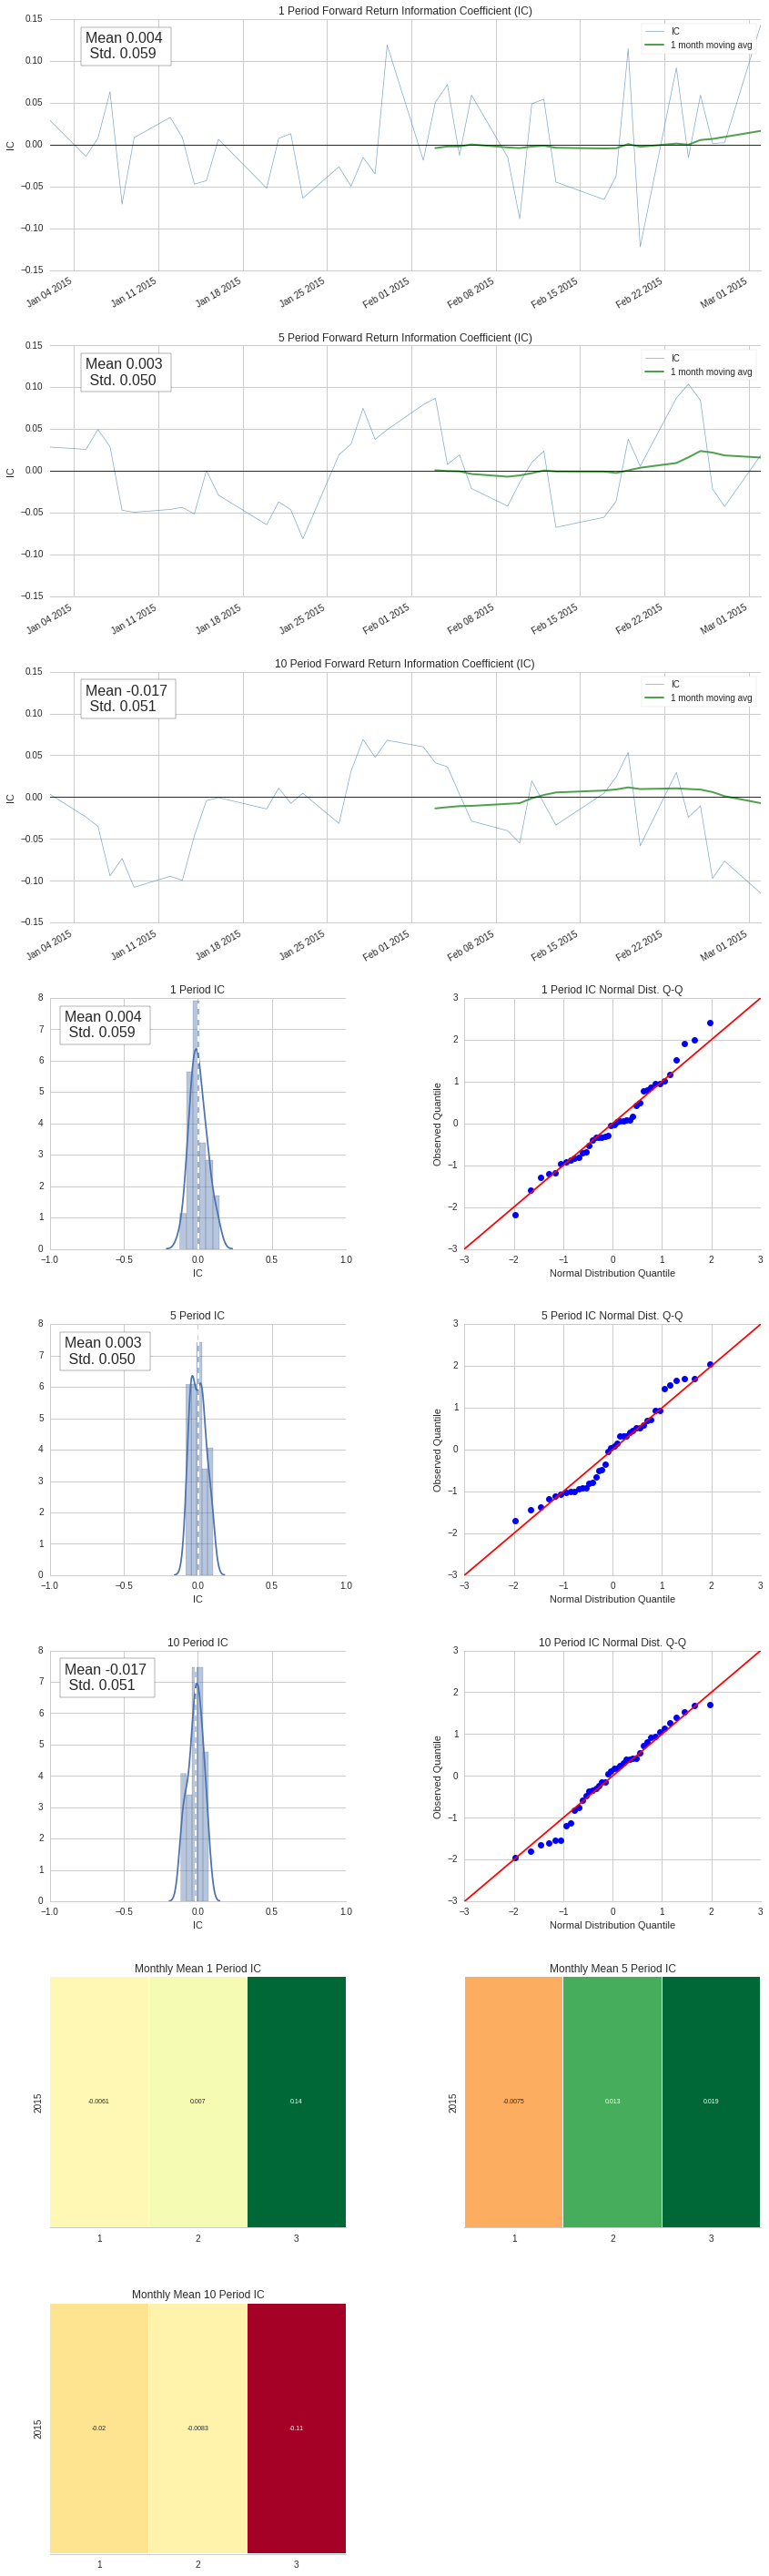

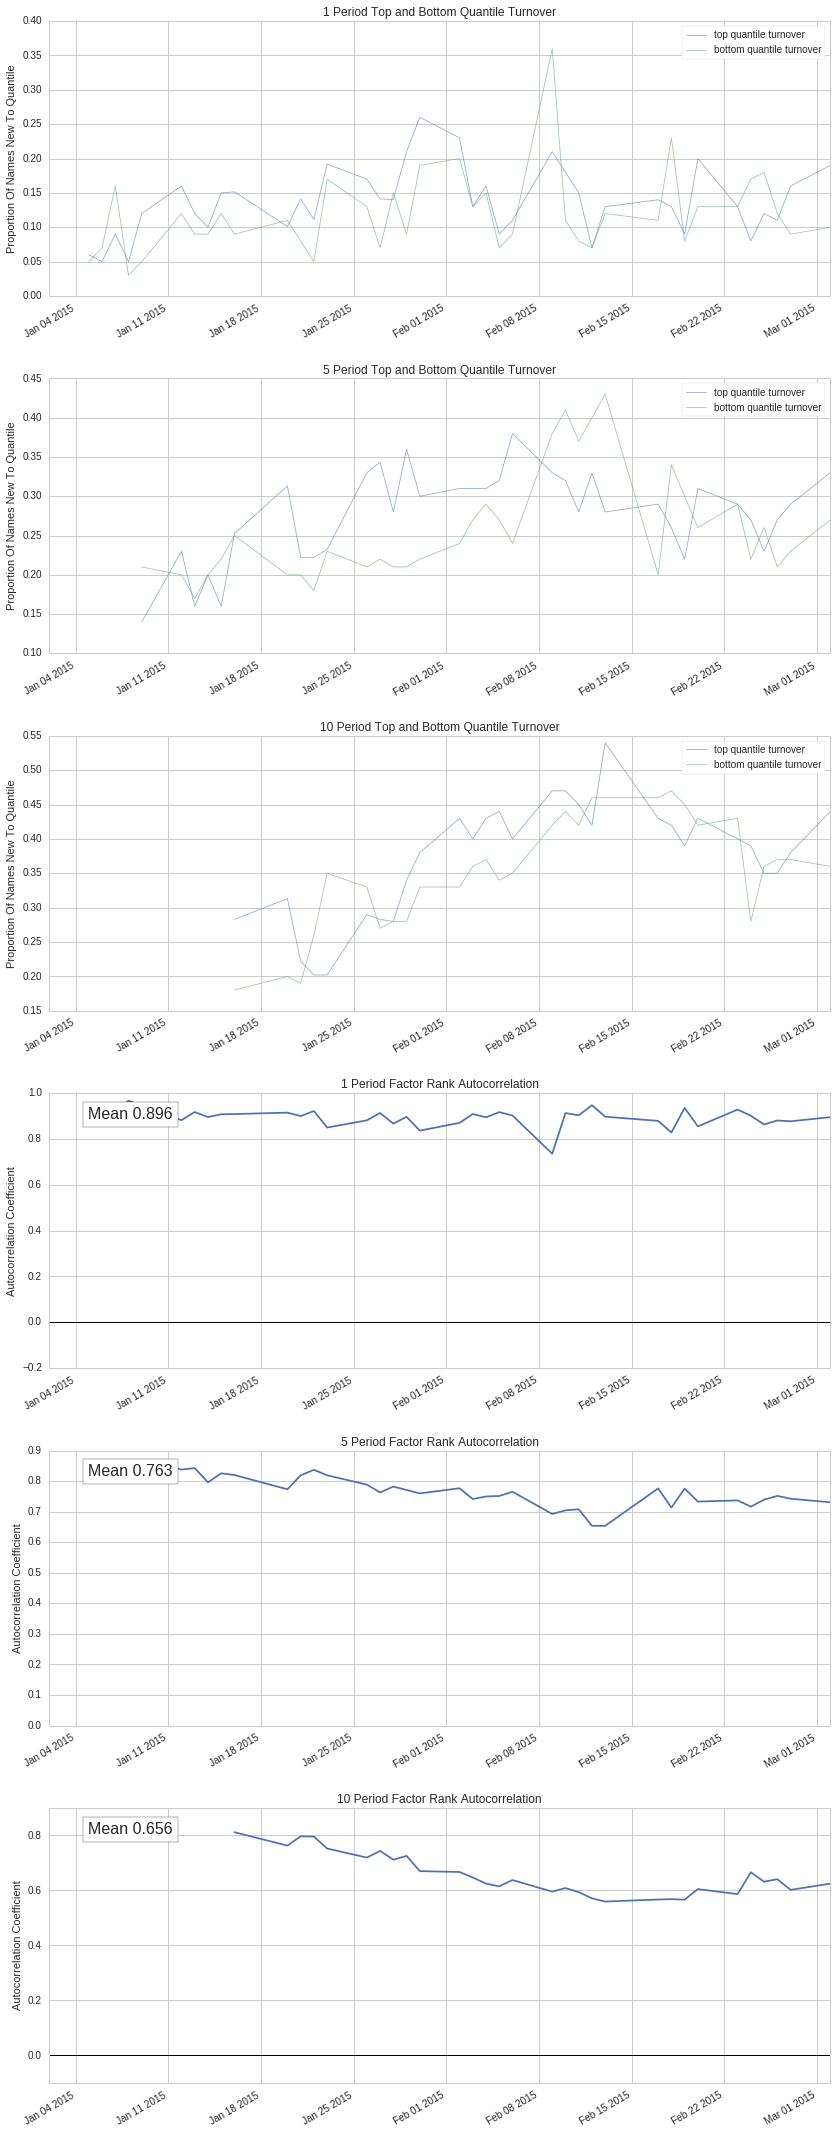

In [159]:
al.tears.create_factor_tear_sheet(results['ML_ranked'], pricing)